### Generating human faces with Adversarial Networks
<img src="images/nvidia_cool_gan.png" width="400px"/>
_© research.nvidia.com_

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .


In [0]:
import sys
sys.path.append("..")

In [0]:
#grading
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import re
import requests
import json


class Grader(object):
    def __init__(self, assignment_key, all_parts=()):
        """
        Assignment key is the way to tell Coursera which problem is being submitted.
        """
        self.submission_page = \
            'https://hub.coursera-apps.org/api/onDemandProgrammingScriptSubmissions.v1'
        self.assignment_key = assignment_key
        self.answers = {part: None for part in all_parts}

    def submit(self, email, token):
        submission = {
                    "assignmentKey": self.assignment_key,
                    "submitterEmail": email,
                    "secret": token,
                    "parts": {}
        }
        for part, output in self.answers.items():
            if output is not None:
                submission["parts"][part] = {"output": output}
            else:
                submission["parts"][part] = dict()
        request = requests.post(self.submission_page, data=json.dumps(submission))
        response = request.json()
        if request.status_code == 201:
            print('Submitted to Coursera platform. See results on assignment page!')
        elif u'details' in response and u'learnerMessage' in response[u'details']:
            print(response[u'details'][u'learnerMessage'])
        else:
            print("Unknown response from Coursera: {}".format(request.status_code))
            print(response)

    def set_answer(self, part, answer):
        """Adds an answer for submission. Answer is expected either as string, number, or
           an iterable of numbers.
           Args:
              part - str, assignment part id
              answer - answer to submit. If non iterable, appends repr(answer). If string,
                is appended as provided. If an iterable and not string, converted to
                space-delimited repr() of members.
        """
        if isinstance(answer, str):
            self.answers[part] = answer
        else:
            try:
                self.answers[part] = " ".join(map(repr, answer))
            except TypeError:
                self.answers[part] = repr(answer)


def array_to_grader(array, epsilon=1e-4):
    """Utility function to help preparing Coursera grading conditions descriptions.
    Args:
       array: iterable of numbers, the correct answers
       epslion: the generated expression will accept the answers with this absolute difference with
         provided values
    Returns:
       String. A Coursera grader expression that checks whether the user submission is in
         (array - epsilon, array + epsilon)"""
    res = []
    for element in array:
        if isinstance(element, int):
            res.append("[{0}, {0}]".format(element))
        else:
            res.append("({0}, {1})".format(element - epsilon, element + epsilon))
    return " ".join(res)


In [0]:
#tqdm_utils
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function
import tqdm
tqdm.monitor_interval = 0  # workaround for https://github.com/tqdm/tqdm/issues/481


class SimpleTqdm():
    def __init__(self, iterable=None, total=None, **kwargs):
        self.iterable = list(iterable) if iterable is not None else None
        self.total = len(self.iterable) if self.iterable is not None else total
        assert self.iterable is not None or self.total is not None
        self.current_step = 0
        self.print_frequency = max(self.total // 50, 1)
        self.desc = ""

    def set_description_str(self, desc):
        self.desc = desc

    def set_description(self, desc):
        self.desc = desc

    def update(self, steps):
        last_print_step = (self.current_step // self.print_frequency) * self.print_frequency
        i = 1
        while last_print_step + i * self.print_frequency <= self.current_step + steps:
            print("*", end='')
            i += 1
        self.current_step += steps

    def close(self):
        print("\n" + self.desc)

    def __iter__(self):
        assert self.iterable is not None
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.total:
            element = self.iterable[self.index]
            self.update(1)
            self.index += 1
            return element
        else:
            self.close()
            raise StopIteration


def tqdm_notebook_failsafe(*args, **kwargs):
    try:
        return tqdm.tqdm_notebook(*args, **kwargs)
    except:
        # tqdm is broken on Google Colab
        return SimpleTqdm(*args, **kwargs)

In [0]:
#keras_utils
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from collections import defaultdict
import numpy as np
from keras.models import save_model
import tensorflow as tf
import keras
from keras import backend as K


class TqdmProgressCallback(keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print('\nEpoch %d/%d' % (epoch + 1, self.epochs))
        if "steps" in self.params:
            self.use_steps = True
            self.target = self.params['steps']
        else:
            self.use_steps = False
            self.target = self.params['samples']
        self.prog_bar = tqdm_notebook_failsafe(total=self.target)
        self.log_values_by_metric = defaultdict(list)

    def _set_prog_bar_desc(self, logs):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values_by_metric[k].append(logs[k])
        desc = "; ".join("{0}: {1:.4f}".format(k, np.mean(values)) for k, values in self.log_values_by_metric.items())
        if hasattr(self.prog_bar, "set_description_str"):  # for new tqdm versions
            self.prog_bar.set_description_str(desc)
        else:
            self.prog_bar.set_description(desc)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        if self.use_steps:
            self.prog_bar.update(1)
        else:
            batch_size = logs.get('size', 0)
            self.prog_bar.update(batch_size)
        self._set_prog_bar_desc(logs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._set_prog_bar_desc(logs)
        self.prog_bar.update(1)  # workaround to show description
        self.prog_bar.close()


class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s


Using TensorFlow backend.


In [0]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import shutil
import requests
import time
from functools import wraps
import traceback


# https://www.saltycrane.com/blog/2009/11/trying-out-retry-decorator-python/
def retry(ExceptionToCheck, tries=4, delay=3, backoff=2):
    def deco_retry(f):

        @wraps(f)
        def f_retry(*args, **kwargs):
            mtries, mdelay = tries, delay
            while mtries > 1:
                try:
                    return f(*args, **kwargs)
                except KeyboardInterrupt as e:
                    raise e
                except ExceptionToCheck as e:
                    print("%s, retrying in %d seconds..." % (str(e), mdelay))
                    traceback.print_exc()
                    time.sleep(mdelay)
                    mtries -= 1
                    mdelay *= backoff
            return f(*args, **kwargs)

        return f_retry  # true decorator

    return deco_retry


@retry(Exception)
def download_file(url, file_path):
    r = requests.get(url, stream=True)
    total_size = int(r.headers.get('content-length'))
    bar = tqdm_utils.tqdm_notebook_failsafe(total=total_size, unit='B', unit_scale=True)
    bar.set_description(os.path.split(file_path)[-1])
    incomplete_download = False
    try:
        with open(file_path, 'wb', buffering=16 * 1024 * 1024) as f:
            for chunk in r.iter_content(4 * 1024 * 1024):
                f.write(chunk)
                bar.update(len(chunk))
    except Exception as e:
        raise e
    finally:
        bar.close()
        if os.path.exists(file_path) and os.path.getsize(file_path) != total_size:
            incomplete_download = True
            os.remove(file_path)
    if incomplete_download:
        raise Exception("Incomplete download")


def download_from_github(version, fn, target_dir):
    url = "https://github.com/hse-aml/intro-to-dl/releases/download/{0}/{1}".format(version, fn)
    file_path = os.path.join(target_dir, fn)
    download_file(url, file_path)


def sequential_downloader(version, fns, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for fn in fns:
        download_from_github(version, fn, target_dir)


def link_all_files_from_dir(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    if not os.path.exists(src_dir):
        # Coursera "readonly/readonly" bug workaround
        src_dir = src_dir.replace("readonly", "readonly/readonly")
    for fn in os.listdir(src_dir):
        src_file = os.path.join(src_dir, fn)
        dst_file = os.path.join(dst_dir, fn)
        if os.name == "nt":
            shutil.copyfile(src_file, dst_file)
        else:
            if os.path.islink(dst_file):
                os.remove(dst_file)
            if not os.path.exists(dst_file):
                os.symlink(os.path.abspath(src_file), dst_file)


def download_all_keras_resources(keras_models, keras_datasets):
    # Originals:
    # http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    # https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
    # https://s3.amazonaws.com/img-datasets/mnist.npz
    sequential_downloader(
        "v0.2",
        [
            "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
        ],
        keras_models
    )
    sequential_downloader(
        "v0.2",
        [
            "cifar-10-batches-py.tar.gz",
            "mnist.npz"
        ],
        keras_datasets
    )


def download_week_3_resources(save_path):
    # Originals:
    # http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
    # http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
    sequential_downloader(
        "v0.3",
        [
            "102flowers.tgz",
            "imagelabels.mat"
        ],
        save_path
    )


def download_week_4_resources(save_path):
    # Originals
    # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
    # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
    # http://vis-www.cs.umass.edu/lfw/lfw.tgz
    sequential_downloader(
        "v0.4",
        [
            "lfw-deepfunneled.tgz",
            "lfw.tgz",
            "lfw_attributes.txt"
        ],
        save_path
    )


def download_week_6_resources(save_path):
    # Originals:
    # http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
    sequential_downloader(
        "v0.1",
        [
            "captions_train-val2014.zip",
            "train2014_sample.zip",
            "train_img_embeds.pickle",
            "train_img_fns.pickle",
            "val2014_sample.zip",
            "val_img_embeds.pickle",
            "val_img_fns.pickle"
        ],
        save_path
    )


def link_all_keras_resources():
    link_all_files_from_dir("../readonly/keras/datasets/", os.path.expanduser("~/.keras/datasets"))
    link_all_files_from_dir("../readonly/keras/models/", os.path.expanduser("~/.keras/models"))


def link_week_3_resources():
    link_all_files_from_dir("../readonly/week3/", ".")


def link_week_4_resources():
    link_all_files_from_dir("../readonly/week4/", ".")


def link_week_6_resources():
    link_all_files_from_dir("../readonly/week6/", ".")

In [0]:
#download_utils.link_week_4_resources()

!wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz


--2019-09-26 16:42:18--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

lfw_attributes.txt  100%[===================>]  14.19M  15.5MB/s    in 0.9s    

2019-09-26 16:42:20 (15.5 MB/s) - ‘lfw_attributes.txt’ saved [14879205/14879205]

--2019-09-26 16:42:21--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M  25.9MB/s    in 5.4s    

2019-09-26 1

In [0]:
#lfw_dataset
import numpy as np
import os
import cv2
import pandas as pd
import tarfile


ATTRS_NAME = "lfw_attributes.txt"  # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
IMAGES_NAME = "lfw-deepfunneled.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
RAW_IMAGES_NAME = "lfw.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw.tgz


def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs.columns = list(df_attrs.columns)[1:] + ["NaN"]
    df_attrs = df_attrs.drop("NaN", axis=1)
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm_notebook_failsafe(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from lfw_dataset import load_lfw_dataset 
data,attrs = load_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

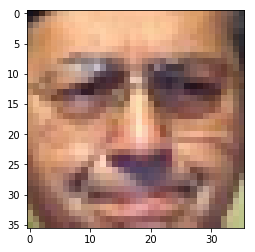

In [0]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="images/noise_to_face.png" width="400px"/>
_© torch.github.io_

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [0]:
import tensorflow as tf

s = reset_tf_session()

import keras
from keras.models import Sequential
from keras import layers as L

#!pip3 install --upgrade tensorflow
#!pip3 install --upgrade tensorflow-gpu

#!pip install --upgrade tensorflow==1.7.0


import tensorflow as tf
tf.__version__

'1.14.0'

In [0]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2D(3,kernel_size=3,activation=None))


In [0]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [0]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

#<build discriminator body>
discriminator.add(L.Conv2D(filters=16, kernel_size=(3, 3), strides=1))
discriminator.add(L.LeakyReLU(0.12))
discriminator.add(L.Conv2D(filters=32, kernel_size=(3, 3), strides=1))
discriminator.add(L.LeakyReLU(0.12))
discriminator.add(L.MaxPool2D(pool_size=(2, 2)))
discriminator.add(L.Conv2D(filters=32, kernel_size=(3, 3), strides=1))
discriminator.add(L.LeakyReLU(0.12))

discriminator.add(L.Conv2D(filters=64, kernel_size=(3, 3), strides=1))
discriminator.add(L.LeakyReLU(0.12))
discriminator.add(L.MaxPool2D(pool_size=(2, 2)))


discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))


# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

<img src="images/gan.png" width="600px"/>
_© deeplearning4j.org_

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [0]:
noise = tf.placeholder('float32',[None,CODE_SIZE])
real_data = tf.placeholder('float32',[None,]+list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)


In [0]:
########################
#discriminator training#
########################

d_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

#regularize
d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

#optimize
disc_optimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss,var_list=discriminator.trainable_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
########################
###generator training###
########################

g_loss = -tf.reduce_mean(logp_gen[:,1])

gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(g_loss,var_list=generator.trainable_weights)

In [0]:
s.run(tf.global_variables_initializer())

### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [0]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

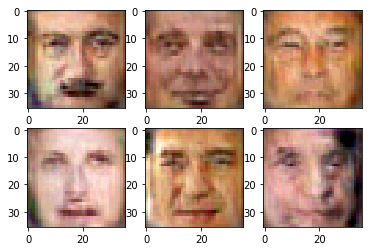

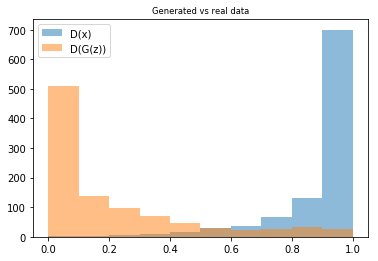

24700
Buffered data was truncated after reaching the output size limit.

In [0]:
from IPython import display

for epoch in tqdm_notebook_failsafe(range(25000)):
    
    feed_dict = {
        real_data:sample_data_batch(100),
        noise:sample_noise_batch(100)
    }
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,True)
        sample_probas(1000)
        print(epoch)
        

In [0]:
import sys
sys.path.append("..")


def submit_honor(submission, email, token):
    grader = Grader("FCl7G51lEeeeZQ4xJ2nzLA")
    G, D = submission
    grader.set_answer("ryO01", D.output_shape[1])
    grader.set_answer("PmSxZ", G.output_shape[1:])
    grader.submit(email, token)


In [0]:
submit_honor((generator, discriminator), "", "")

Submitted to Coursera platform. See results on assignment page!


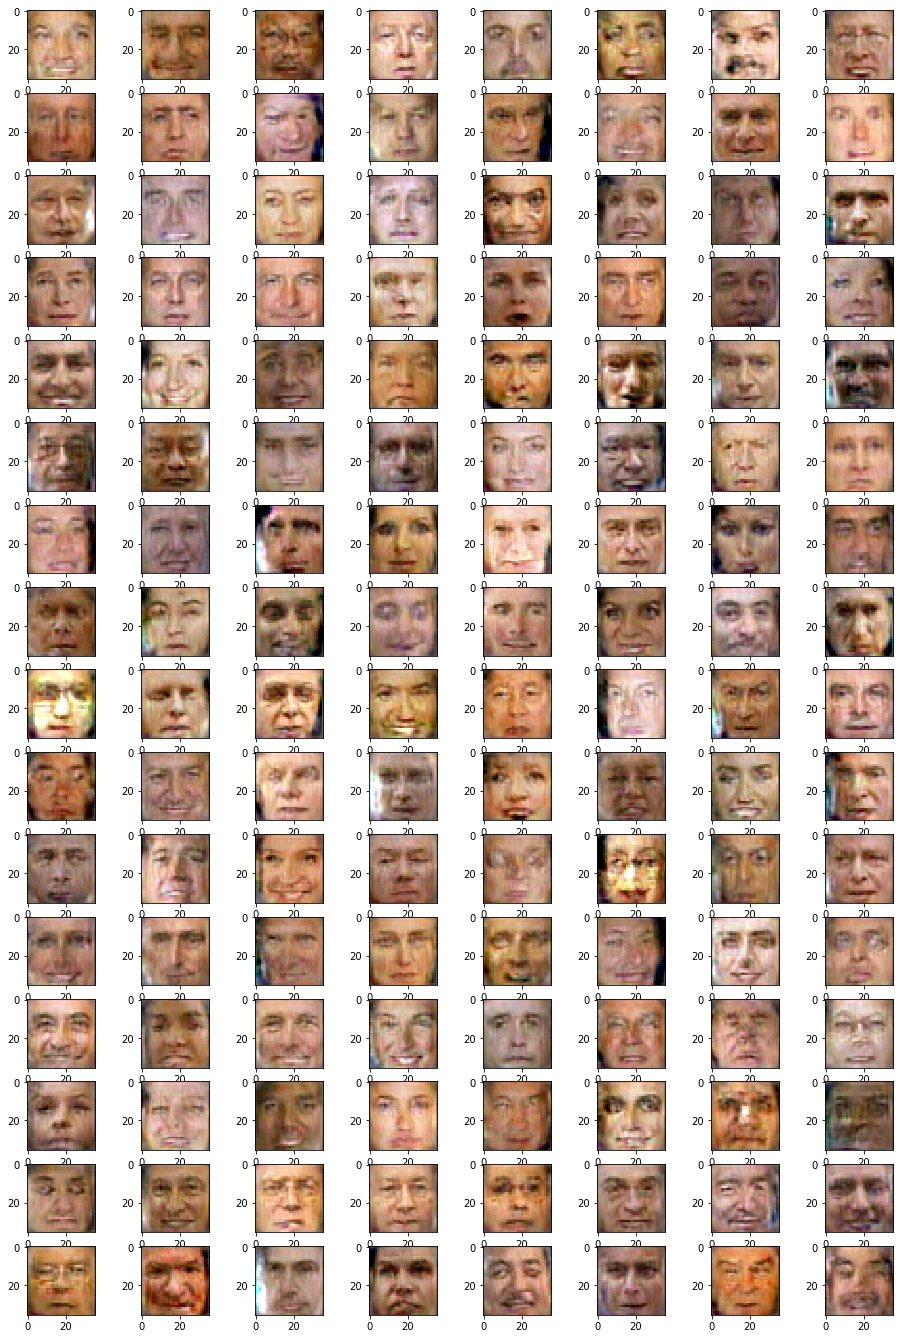

In [0]:
plt.figure(figsize=[16,24])
sample_images(16,8)